In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl
import copy

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp

from fusiondls import run_dls, file_read, file_write
from fusiondls.Profile import *
from fusiondls.unpackConfigurationsMK import unpackConfigurationMK
from fusiondls.AnalyticCoolingCurves import LfuncKallenbach



onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))

from DLS.postprocess import *
from code_comparison.solps_pp import *
from sdtools.general.plotstyle import change_colors
change_colors("default")

%matplotlib inline

%load_ext autoreload
%autoreload 2


# Read SOLPS case

In [2]:
balance_paths = {
    "100MW_inner_arpuff" : r"C:\Users\Mike\OneDrive\Project\DLS\from ryoko\2024-11-05 - CDN V10 runs\V10_100MW_inner_ar_seed\step0_A5e21D1e24spr",
    "100MW_innerar_midplanepuff" : r"C:\Users\Mike\OneDrive\Project\DLS\from ryoko\2024-11-05 - CDN V10 runs\V10_100MW_inner_ar_seed_impomp_puff\step2_Xomp20_A8e21D0p4e24sp50r",
}

store_slc = {}

for case in balance_paths:
    print(case)
    if "balance.nc" in os.listdir(balance_paths[case]):
        store_slc[case] = SOLPScase(balance_paths[case])
        store_slc[case].get_species()
        store_slc[case].get_impurity_stats("Ar", all_states = True)
    else:
        print(f"Skipping {case} as no balance.nc file found")
        
case = "100MW_innerar_midplanepuff"
sepadd_select = dict(outer_lower = 2, inner_lower = 1)

100MW_inner_arpuff
Saving all states
Added total radiation, density and fraction for Ar
100MW_innerar_midplanepuff
Saving all states
Added total radiation, density and fraction for Ar


# Common formatting stuff

In [3]:
labels = {'100MW_inner_arpuff' : "PFR puff", '100MW_innerar_midplanepuff' : "Midplane puff"}

# Prepare cooling curves

In [5]:
curves = {}
T = np.linspace(0, 200, 1000)

In [16]:



class CoolingCurves:
    """
    Curves are stored as curves[source][species][neTau]
    """

    def __init__(self):
        self.curves = {}
        self.curves["radas"] = {}
        pass

    def read_radas(self, species, path):
        """
        Read radas outputs for a single species, interpolate and store
        """
        ds = xr.open_dataset(path)

        self.curves["radas"][species] = {}

        for netau in ds.coords["dim_ne_tau"].values:
            rate = ds["equilibrium_Lz"].sel(
                dim_ne_tau=netau, dim_electron_density=1e20, method="nearest"
            )
            netau_name = netau
            self.curves["radas"][species][netau_name] = sp.interpolate.interp1d(
                ds.coords["dim_electron_temp"].values,
                rate.values,
                kind="cubic",
                fill_value=(rate.values[0], rate.values[-1]),
                bounds_error=False,
            )

    def read_solps(self, case, species, region, sepadd, order=8):
        if "solps" not in self.curves.keys():
            self.curves["solps"] = {}
            if region not in self.curves["solps"].keys():
                self.curves["solps"][region] = {}

        self.curves["solps"][region][sepadd] = case.extract_cooling_curve(
            species, region, sepadd=sepadd, order=order
        )
        
    def plot_curve(name):
        


curves = CoolingCurves()
curves.read_radas(
    "Ar", r"C:\Users\Mike\OneDrive\Project\DLS\radas-curves\radas_dir\output\argon.nc"
)

curves.curves["radas"]["Ar"]


{100000000000.0: <scipy.interpolate._interpolate.interp1d at 0x14edb66a350>,
 1000000000000.0: <scipy.interpolate._interpolate.interp1d at 0x14edb66a3a0>,
 10000000000000.0: <scipy.interpolate._interpolate.interp1d at 0x14edb6694f0>,
 100000000000000.0: <scipy.interpolate._interpolate.interp1d at 0x14edb669680>,
 1000000000000000.0: <scipy.interpolate._interpolate.interp1d at 0x14edb668820>,
 1e+16: <scipy.interpolate._interpolate.interp1d at 0x14edb669ea0>,
 1e+17: <scipy.interpolate._interpolate.interp1d at 0x14edb669630>,
 1e+18: <scipy.interpolate._interpolate.interp1d at 0x14edb669900>,
 1e+19: <scipy.interpolate._interpolate.interp1d at 0x14edb669bd0>,
 1e+20: <scipy.interpolate._interpolate.interp1d at 0x14edb669e50>}

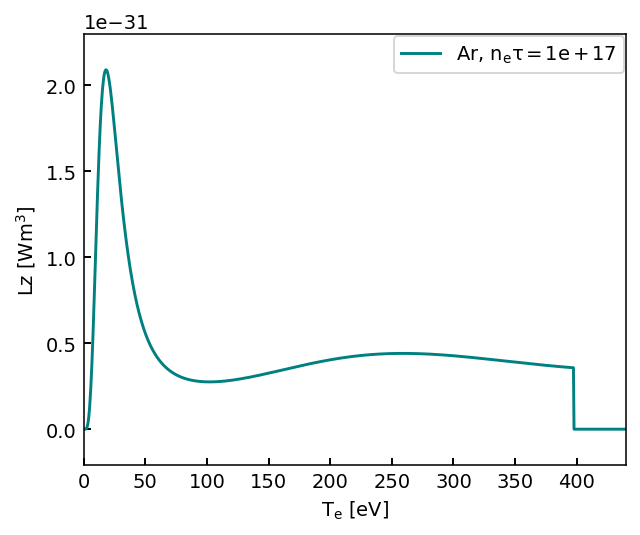

In [44]:
class CoolingCurve:
    def __init__(self, T, Lz, neTau, species, order=8, Tmin=0.5, Tmax=400):
        self.data_original = pd.DataFrame()
        self.data_original["T"] = T
        self.data_original["Lz"] = Lz

        self.neTau = neTau
        self.species = species
        self.order = order
        self.Tmax = Tmax
        self.Tmin = Tmin
        self.resolution = 1000

        self.interpolate()

    def interpolate(self):
        """
        Note that the resulting Tmax may not be the same as specified as input.
        This is because the original data may not have a value exactly at Tmax -
        this means it's clipped to the nearest value under Tmax.
        """

        original_clipped = self.data_original[
            (self.Tmin < self.data_original["T"])
            & (self.data_original["T"] <= self.Tmax)
        ]

        logx = np.log10(original_clipped["T"].values)
        logy = np.log10(original_clipped["Lz"].values)

        coeffs = np.polyfit(logx, logy, self.order)

        def Lz_func(T):
            if T < self.Tmin:
                return 0
            elif T > original_clipped["T"].max():
                return 0
            else:
                return 10 ** np.polyval(coeffs, np.log10(T))

        self.Lz_func = Lz_func
        self.data = pd.DataFrame()
        self.data["T"] = np.linspace(0, self.Tmax + 50, self.resolution)
        self.data["Lz"] = [Lz_func(T) for T in self.data["T"]]

    def plot(self, ax=None, xmax=None, show_fit=False, label="", **kwargs):
        """
        Kwargs are passed to line plot of fitted curve
        """

        if xmax is None:
            xmax = self.Tmax * 1.1

            if ax is None:
        fig, ax = plt.subplots()

        if show_fit:
            ax.plot(
                self.data_original["T"],
                self.data_original["Lz"],
                marker="o",
                lw=0,
                label="Original data",
            )

            label = "Fit"
        elif label != "":
            label = label
        else:
            label = f"{self.species}, $n_{{e}} \\tau = {self.neTau}$"

        ax.plot(self.data["T"], self.data["Lz"], label=label, **kwargs)
        ax.set_xlim(0, xmax)
        ax.set_xlabel("$T_e$ [eV]")
        ax.set_ylabel("Lz [$Wm^3$]")
        ax.legend()


ds = xr.open_dataset(
    r"C:\Users\Mike\OneDrive\Project\DLS\radas-curves\radas_dir\output\argon.nc"
)


curve = CoolingCurve(
    T=ds.coords["dim_electron_temp"].values,
    Lz=ds["equilibrium_Lz"]
    .sel(dim_ne_tau=1e17, dim_electron_density=1e20, method="nearest")
    .values,
    neTau=1e17,
    species="Ar",
)


curve.plot()
curve.interpolate()


In [ ]:
ds = xr.open_dataset(path)

        self.curves["radas"][species] = {}

        for netau in ds.coords["dim_ne_tau"].values:
            rate = ds["equilibrium_Lz"].sel(
                dim_ne_tau=netau, dim_electron_density=1e20, method="nearest"
            )
            netau_name = netau
            self.curves["radas"][species][netau_name] = sp.interpolate.interp1d(
                ds.coords["dim_electron_temp"].values,
                rate.values,
                kind="cubic",
                fill_value=(rate.values[0], rate.values[-1]),
                bounds_error=False,
            )

## radas

In [10]:
rd_Ar = xr.open_dataset(r"C:\Users\Mike\OneDrive\Project\DLS\radas-curves\radas_dir\output\argon.nc")

curves["neTau"] = {}

for netau in rd_Ar.coords["dim_ne_tau"].values:
    rate = rd_Ar["equilibrium_Lz"].sel(dim_ne_tau = netau, dim_electron_density=1e20, method="nearest")
    netau_name = netau
    curves["neTau"][netau_name] = sp.interpolate.interp1d(
        rd_Ar.coords["dim_electron_temp"].values, rate.values, kind = "cubic",
        fill_value = (rate.values[0], rate.values[-1]), bounds_error = False
        )




Data variables:
    charge_state_evolution             (dim_electron_temp, dim_electron_density, dim_ne_tau, dim_charge_state, dim_time) float64 95MB ...
    equilibrium_charge_state_fraction  (dim_electron_temp, dim_electron_density, dim_ne_tau, dim_charge_state) float64 2MB ...
    equilibrium_mean_charge_state      (dim_electron_temp, dim_electron_density, dim_ne_tau) float64 100kB ...
    equilibrium_Lz                     (dim_electron_temp, dim_electron_density, dim_ne_tau) float64 100kB ...
    coronal_mean_charge_state          (dim_electron_temp, dim_electron_density) float64 10kB ...
    coronal_Lz                         (dim_electron_temp, dim_electron_density) float64 10kB ...
    electron_temp                      (dim_electron_temp) float64 384B ...
    electron_density                   (dim_electron_density) float64 208B ...
    effective_recombination            (dim_charge_state, dim_electron_temp, dim_electron_density) float64 190kB ...
    effective_ionisation     

## SOLPS

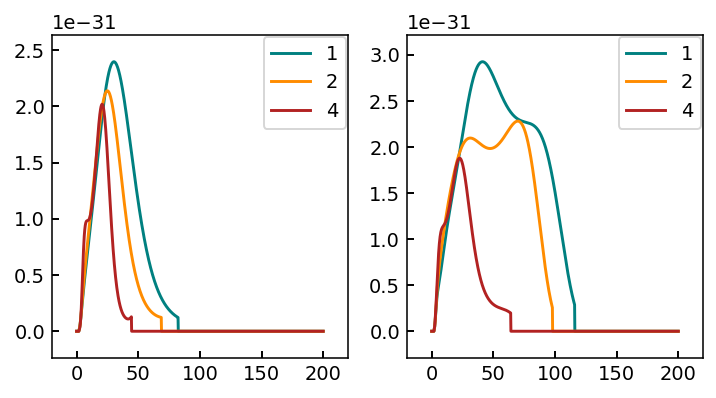

In [8]:
curves["extracted_outer"] = {}
curves["extracted_inner"] = {}

for i in range(8):
    curves["extracted_outer"][i] = store_slc[case].extract_cooling_curve("Ar", "outer_lower", sepadd = i, order = 10)
    curves["extracted_inner"][i] = store_slc[case].extract_cooling_curve("Ar", "inner_lower", sepadd = i, order = 8)
    
    
fig, axes = plt.subplots(1,2, figsize = (6,3))

for i in [1,2,4]:

    axes[0].plot(T, [curves["extracted_inner"][i](temp) for temp in T], label = i)
    axes[1].plot(T, [curves["extracted_outer"][i](temp) for temp in T], label = i)
    
for ax in axes:
    ax.legend()


## Custom

In [9]:
def LfuncArParametricTriShoulder(T, x1 = 0, x2 = 60, height = 0.5):
    """
    Analytical approximation of the Ar cooling curve
    Tmax is the temperature at which the radiation goes to zero on the hot end
    
    """
    
    # Maximum from actual Ar curve
    max = 1.7210363586464083e-31
    
    x0 = 0
    y0 = 0
    # x1 = max_pos
    y1 = max
    # x2 = 
    y2 = max * height
    

    if T < x1:
        Lz = (y0 * (x1 - T) + y1 * (T - x0)) / (x1 - x0)
    elif T >= x1 and T < x2:
        Lz = (y1 * (x2 - T) + y2 * (T - x1)) / (x2 - x1)
    else:
        Lz = y2

    
    return Lz

## Compare curves

### Outer

(-10.0, 200.0)

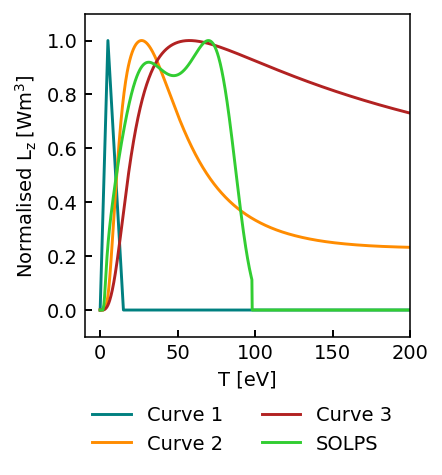

In [10]:
curves["set_outer"] = {
    "Curve 1" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 5, x2 = 15, height = 0),
    "Curve 2" : curves["neTau"][1e16],
    "Curve 3" : curves["neTau"][1e14],
    "SOLPS" : curves["extracted_outer"][sepadd_select["outer_lower"]],
    
}
    
fig, ax = plt.subplots(figsize = (3,3))


for name, function in curves["set_outer"].items():
    Lz = [function(temp) for temp in T]
    Lz = Lz/np.max(Lz)
    ax.plot(T, Lz, lw = 1.5, label = name)

ax.set_xlabel("T [eV]")
ax.set_ylabel(r"Normalised $L_z\ [W m^{3}]$")
fig.legend(loc = "upper center", bbox_to_anchor = (0.5,-0.03), ncol = 2, frameon = False)
ax.set_xlim(-10,200)

### Inner

(-10.0, 200.0)

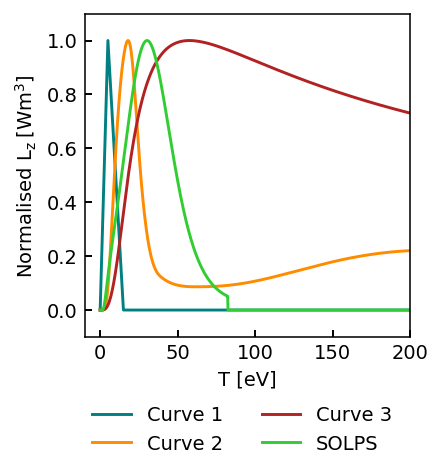

In [11]:
curves["set_inner"] = {
    "Curve 1" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 5, x2 = 15, height = 0),
    "Curve 2" : curves["neTau"][1e20],
    "Curve 3" : curves["neTau"][1e14],
    "SOLPS" : curves["extracted_inner"][sepadd_select["inner_lower"]],
    # "neon" : LfuncKallenbach("Ne")
    # "shoulder" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 23, x2 = 50, height = 0.27),
    # "nitrogen" : lambda temp: LfuncKallenbach("N")(temp),
    # "argon" : lambda temp: LfuncKallenbach("Ar")(temp),
    # "neon" : lambda temp: LfuncKallenbach("Ne")(temp),
    
}
    
fig, ax = plt.subplots(figsize = (3,3))


for name, function in curves["set_inner"].items():
    Lz = [function(temp) for temp in T]
    Lz = Lz/np.max(Lz)
    ax.plot(T, Lz, lw = 1.5, label = name)

ax.set_xlabel("T [eV]")
ax.set_ylabel(r"Normalised $L_z\ [W m^{3}]$")
fig.legend(loc = "upper center", bbox_to_anchor = (0.5,-0.03), ncol = 2, frameon = False)
ax.set_xlim(-10,200)

# Run DLS

In [12]:
def run_DLS(constants_input, profile, SparRange, slc, cvar, region, sepadd, hflux_corr = 1, atol = 1e-10, rtol = 1e-5):
    if "Lfunc" not in constants_input.keys():
        print("WARNING: NO COOLING CURVE PROVIDED")
    # set switches
    radios_default = {
        "upstreamGrid": True,  # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point.
    }
    
    df = slc.get_1d_poloidal_data(["Ne"], sepadd = sepadd, region = region, target_first = True)
    nu = df["Ne"].iloc[-1]

    # set general run parameters
    constants_default = {
        "gamma_sheath": 7,  # sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
        "Tt": 0.5,  # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
        "qpllu0": 3.42e8,
        "nu": nu,  # Upstream density (if constant)
        "nu0": nu,  # Upstream density (if constant)
        "cz0": 0.05,  # Impurity fraction (if constant)
        # "Lfunc": LfuncKallenbach("N"),  # impurity cooling function. More are available in AnalyticCoolingCurves.py
        "Lfunc" : slc.extract_cooling_curve("Ar", region, sepadd = sepadd, plot = False),
        "kappa0" : slc.extract_kappa0(sepadd = sepadd, region = region)
    }
    
    # if Spar == "auto":
    #     Spar = slc.extract_front_pos(sepadd = sepadd, region = region, impurity = "Ar", method = "qpar_tot", threshold = 0.05)

    constants = {**constants_default, **constants_input}

    try: 
            out = run_dls(
                constants = constants, 
                radios = radios_default, 
                d = profile,
                SparRange = SparRange,
                control_variable = cvar,
                verbosity = 0,
                Ctol = 1e-4,
                Ttol = 1e-4,
                atol = atol,
                rtol = rtol,
                dynamicGrid = True,
                dynamicGridRefinementRatio = 5,
                dynamicGridRefinementWidth = 2,
                dynamicGridResolution = 10000,
                dynamicGridDiagnosticPlot = False)
        
    except KeyboardInterrupt:
        print("Stopped")
        sys.exit(0)

    return out, compare_SOLPS_DLS(slc, out, cvar, impurity = "Ar", region = region, sepadd = sepadd)


## Run baseline

## Initialise

In [13]:
nested_dict = lambda: defaultdict(nested_dict)
store_outer = nested_dict()
store_inner = nested_dict()
num_locations = 3
Ttol = 1e-3
Ctol = 1e-3

### Inner

In [25]:
rtols = [1e-4, 1e-5, 1e-6]
atols = [1e-6, 1e-10]

atols

[1e-06, 1e-10]

In [26]:
study = "inner"
region = "inner_lower"

rtols = [1e-4, 1e-5]
atols = [1e-5, 1e-6]

curve = "Curve 1"
for rtol in rtols:
    for atol in atols:
        base_profile_inner = eqb_alt['100MW_innerar_midplanepuff'][region][sepadd_select[region]]
        d = base_profile_inner
        SpolRange = np.linspace(0, d["Spol"][d["Xpoint"]], num_locations) # 
        SparRange = [d["S"][np.argmin(np.abs(d["Spol"] - SpolRange[x]))] for x, _ in enumerate(SpolRange)]
        
        input = dict(Lfunc = curves["set_inner"][curve])
        out, comp = run_DLS(input, base_profile_inner, SparRange, store_slc[case],  "density", region, sepadd_select[region], hflux_corr = 1,
                            atol = atol, rtol = rtol)  
        store_inner[rtol][atol] = out
    

Solving...0.0000...2.5169...

c:\pyenvs\fusion312\Lib\site-packages\scipy\integrate\_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


11.5721...Complete in 14.6 seconds
Solving...0.0000...2.5169...

c:\pyenvs\fusion312\Lib\site-packages\scipy\integrate\_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


11.5721...Complete in 7.8 seconds
Solving...0.0000...2.5169...

c:\pyenvs\fusion312\Lib\site-packages\scipy\integrate\_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


11.5721...Complete in 10.7 seconds
Solving...0.0000...2.5169...

c:\pyenvs\fusion312\Lib\site-packages\scipy\integrate\_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


11.5721...Complete in 11.3 seconds


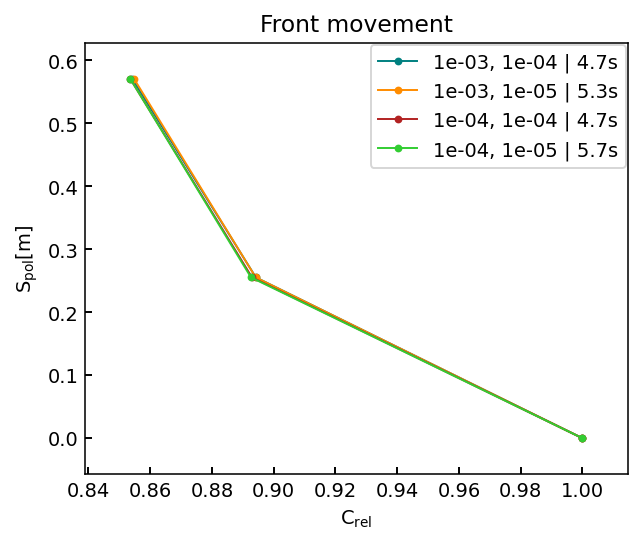

In [25]:
fig, ax = plt.subplots()

for rtol in rtols:
    for atol in atols:
        deck = DLScasedeck(store_inner[rtol][atol])
        speed = store_inner[rtol][atol]["runtime"]
        deck.plot_front_movement(ax = ax, label = f"{rtol:.0e}, {atol:.0e} | {speed:.1f}s", relative = True)
        
ax.legend()